## Can we predict mate8 score?

In this Python notebook, a regression model is setup, trying to predict the score in mathematics in the 8th grade Invalsi test at a school level, only using aggregated information about the 6th grade aggregated result and school level information consisting in indexes concerning the principal's behavior, sociological information and geographical information. 

The aim of this investigation is to give the school inspectorate (Provveditorato) an estimate of the expected results for schools, based on their results, trying to identify the schools which are most at risk. In order to achieve this task, we want to use a model which, at the same time, is powerful enough to spot some nonlinear relationships and interactions between variables, but doesn't overfit too easily and keeps a high level of interpretability.

After trying Generalised Additive Models (GAM), we move to GA2M, GAM with automatic recognition of significant interactions between variables. Moreover, while staying in a semi-parametric framework, we move from using splines to model the nonlinear terms to using boosted trees for the function approximation, which are more suited for a problem of this kind, where variables have more of a 'stepwise' effect, which would result in oscillating terms by approximating with splines with many degrees of freedom. The resulting technique is named EBM (explainable boosting machine).

The resulting model stays interpretable, through exact partial dependency plots, while mantaining an accuracy on par with state of the art boosting techniques (and, on this dataset, with few data available, it manages to outperform consistently both splines and pure boosting, as it tends not to overfit). For more details on the employed technique, see https://arxiv.org/pdf/1909.09223.pdf and https://www.cs.cornell.edu/~yinlou/papers/lou-kdd13.pdf.

If a more compact representation is needed, a priori variable selection can be performed (though the model automatically uses only relevant variables) and the number of interactions can be tuned down. A light hyperparameter tuning can also be done with a custom metric (e.g. keeping the number of interactions low/ searching for a robust model by also taking into account the cross-validation variance).

Then, prediction intervals for the models are built using inductive conformal prediction. The resultant intervals, while valid, do have some problems and do not seem to be too useful for detecting the schools at risk. Moreover, while the model is quite accurate, it tends to always make predictions close to the mean of the results, while learning a meaningful ranking. 

For more actionable insights, we will therefore move to a classification framework, where we try to predict directly the schools at risk (e.g. lower 20th percentile).

In [1]:
import pandas as pd
import numpy as np
from interpret.glassbox import ExplainableBoostingRegressor, ExplainableBoostingClassifier
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('../Data/gppp.csv').set_index('cod_scu_anonimo')
data = data[data.Fattore_correzione > 0.85]
data.describe()

,opinione_invalsi,utilizzo_invalsi,discussi_insegnanti,discussi_genitori,sodd_pon,attivita_preside,pressioni_genitori,coinvolgimento_genitori_prop,opinione_associazioni_genitori,coinvolgimento_genitori_eff,condotta_studenti,registro_elettronico,numero_plessi,infrastrutture,strumenti,preside_maschio,eta_preside,voto_scritto_ita,voto_scritto_mat,voto_scritto_ita_cont,voto_scritto_mat_cont,Pon,Fattore_correzione,statale,paritaria,Nord,Centro,Sud,school_score_ita,school_score_mate,school_escs,class_tot,class_fem,prop_fem,class_imm1,prop_imm1,class_imm2,prop_imm2,class_late,prop_late,public,voto_orale_ita_mean,voto_orale_ita_std,voto_orale_ita_skew,voto_orale_ita_min,voto_orale_ita_max,voto_orale_ita_median,voto_orale_ita_q25,voto_orale_ita_q75,voto_orale_mat_mean,voto_orale_mat_std,voto_orale_mat_skew,voto_orale_mat_min,voto_orale_mat_max,voto_orale_mat_median,voto_orale_mat_q25,voto_orale_mat_q75,voto_orale_ita_cont_mean,voto_orale_ita_cont_std,voto_orale_ita_cont_skew,voto_orale_ita_cont_min,voto_orale_ita_cont_max,voto_orale_ita_cont_median,voto_orale_ita_cont_q25,voto_orale_ita_cont_q75,voto_orale_mat_cont_mean,voto_orale_mat_cont_std,voto_orale_mat_cont_skew,voto_orale_mat_cont_min,voto_orale_mat_cont_max,voto_orale_mat_cont_median,voto_orale_mat_cont_q25,voto_orale_mat_cont_q75,pu_ma_gr_mean,pu_ma_gr_std,pu_ma_gr_skew,pu_ma_gr_min,pu_ma_gr_max,pu_ma_gr_median,pu_ma_gr_q25,pu_ma_gr_q75,pu_ma_no_mean,pu_ma_no_std,pu_ma_no_skew,pu_ma_no_min,pu_ma_no_max,pu_ma_no_median,pu_ma_no_q25,pu_ma_no_q75,part_1_gr_mean,part_1_gr_std,part_1_gr_skew,part_1_gr_min,part_1_gr_max,part_1_gr_median,part_1_gr_q25,part_1_gr_q75,part_1_no_mean,part_1_no_std,part_1_no_skew,part_1_no_min,part_1_no_max,part_1_no_median,part_1_no_q25,part_1_no_q75,part_2_gr_mean,part_2_gr_std,part_2_gr_skew,part_2_gr_min,part_2_gr_max,part_2_gr_median,part_2_gr_q25,part_2_gr_q75,part_2_no_mean,part_2_no_std,part_2_no_skew,part_2_no_min,part_2_no_max,part_2_no_median,part_2_no_q25,part_2_no_q75,part_3_gr_mean,part_3_gr_std,part_3_gr_skew,part_3_gr_min,part_3_gr_max,part_3_gr_median,part_3_gr_q25,part_3_gr_q75,part_3_no_mean,part_3_no_std,part_3_no_skew,part_3_no_min,part_3_no_max,part_3_no_median,part_3_no_q25,part_3_no_q75,part_4_gr_mean,part_4_gr_std,part_4_gr_skew,part_4_gr_min,part_4_gr_max,part_4_gr_median,part_4_gr_q25,part_4_gr_q75,part_4_no_mean,part_4_no_std,part_4_no_skew,part_4_no_min,part_4_no_max,part_4_no_median,part_4_no_q25,part_4_no_q75,proc_1_gr_mean,proc_1_gr_std,proc_1_gr_skew,proc_1_gr_min,proc_1_gr_max,proc_1_gr_median,proc_1_gr_q25,proc_1_gr_q75,proc_2_gr_mean,proc_2_gr_std,proc_2_gr_skew,proc_2_gr_min,proc_2_gr_max,proc_2_gr_median,proc_2_gr_q25,proc_2_gr_q75,proc_3_gr_mean,proc_3_gr_std,proc_3_gr_skew,proc_3_gr_min,proc_3_gr_max,proc_3_gr_median,proc_3_gr_q25,proc_3_gr_q75,proc_1_no_mean,proc_1_no_std,proc_1_no_skew,proc_1_no_min,proc_1_no_max,proc_1_no_median,proc_1_no_q25,proc_1_no_q75,proc_2_no_mean,proc_2_no_std,proc_2_no_skew,proc_2_no_min,proc_2_no_max,proc_2_no_median,proc_2_no_q25,proc_2_no_q75,proc_3_no_mean,proc_3_no_std,proc_3_no_skew,proc_3_no_min,proc_3_no_max,proc_3_no_median,proc_3_no_q25,proc_3_no_q75,WLE_MAT_200_mean,WLE_MAT_200_std,WLE_MAT_200_skew,WLE_MAT_200_min,WLE_MAT_200_max,WLE_MAT_200_median,WLE_MAT_200_q25,WLE_MAT_200_q75,WLE_MAT_200_CORR_mean,WLE_MAT_200_CORR_std,WLE_MAT_200_CORR_skew,WLE_MAT_200_CORR_min,WLE_MAT_200_CORR_max,WLE_MAT_200_CORR_median,WLE_MAT_200_CORR_q25,WLE_MAT_200_CORR_q75,mate8_mean,mate8_std,mate8_skew,mate8_min,mate8_max,mate8_median,mate8_q25,mate8_q75,pu_it_gr_mean,pu_it_gr_std,pu_it_gr_skew,pu_it_gr_min,pu_it_gr_max,pu_it_gr_median,pu_it_gr_q25,pu_it_gr_q75,pu_it_no_mean,pu_it_no_std,pu_it_no_skew,pu_it_no_min,pu_it_no_max,pu_it_no_median,pu_it_no_q25,pu_it_no_q75,WLE_ITA_200_mean,WLE_ITA_200_std,WLE_ITA_200_skew,WLE_ITA_200_min,WLE_ITA_200_max,WLE_ITA_200_median,WLE_ITA_200_q25,WLE_ITA_200_q75,WLE_ITA_200_CORR_mean,WLE_ITA_200_CORR_std,WLE_ITA_200_CORR_skew,WLE_ITA_200_CORR_min,WLE_ITA_200_COR

In [3]:
seed = 13
label = 'mate8_mean'
cols = [ 'opinione_invalsi',
         'utilizzo_invalsi',
         'discussi_insegnanti',
         'discussi_genitori',
         'sodd_pon',
         'attivita_preside',
         'pressioni_genitori',
         'coinvolgimento_genitori_prop',
         'opinione_associazioni_genitori',
         'coinvolgimento_genitori_eff',
         'condotta_studenti',
         'registro_elettronico',
         'numero_plessi',
         'infrastrutture',
         'strumenti',
         'preside_maschio',
         'eta_preside',
         'prop_maschi',
         'prop_laurea_padre',
         'prop_laurea_madre',
         'prop_diploma_padre',
         'prop_diploma_madre',
         'prop_padre_ita',
         'prop_madre_ita',
         'prop_padre_disocc',
         'prop_madre_disocc',
         'prop_bocciati',
         'ita6_mean',
         'mate6_mean',
         'ESCS_mean',
         'Sud',
         'Nord',
         'Centro',
         'ESCS_std',
         'ESCS_skew',
        
        
         label]

X = data[cols].dropna()
y = X[label]
X.drop(label,axis=1,inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = seed)

ebm = ExplainableBoostingRegressor(max_interaction_bins = 45, interactions = 5, outer_bags = 7,
                                             inner_bags = 12, learning_rate = 0.01718, validation_size = 0.3, 
                                             early_stopping_rounds = 78, early_stopping_tolerance = 1e-6,
                                             max_rounds = 5700, min_samples_leaf = 2, max_leaves = 2,
                                             random_state=seed, n_jobs=-1)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(early_stopping_rounds=78,
                             early_stopping_tolerance=1e-06,
                             feature_names=['opinione_invalsi',
                                            'utilizzo_invalsi',
                                            'discussi_insegnanti',
                                            'discussi_genitori', 'sodd_pon',
                                            'attivita_preside',
                                            'pressioni_genitori',
                                            'coinvolgimento_genitori_prop',
                                            'opinione_associazioni_genitori',
                                            'coinvolgimento_genitori_eff',
                                            'condotta_studenti',
                                            'regi...
                                            'continuous', 'continuous',
                                            'continuous', 'cont

These plots are built automatically in a dashboard, so the code has to be run in order to see them and interact with them.
Here, global explainability for the full model is shown through feature importances and pdp.

In [4]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7340/2535341726544/ -->

In [5]:
from interpret.perf import RegressionPerf

ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7340/2535923290512/ -->

Feature selection is hereby performed through a simple hill climbing wrapper algorithm, to be optimized for the desired target. 

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  KFold
from sklearn.model_selection import train_test_split

n_splits = 4
cv = KFold(n_splits=n_splits, shuffle = True, random_state = 1220)

In [7]:
import random
random.seed(10)
np.random.seed(10)

def HillClimbing(number_of_variables,number_of_evaluations,evaluation_function, verbose = True):

    # current evaluation
    evaluations = 0
    
    # start from a random set of features
    current_feature_subset = [np.random.choice(2, p=[0,1]) for x in range(number_of_variables)]

    # that will also provide an initial evaluation of the best performance
    best_performance = evaluation_function(current_feature_subset)
    if verbose :
        print("%5d\t\t%3.4f\t%s"%(evaluations,best_performance,X.columns[[bool(x) for x in current_feature_subset]]))
    
    # continue until all the evaluations have been performed
    search = 0.2 * number_of_evaluations
    while evaluations< search:
        perturbation = [np.random.choice(2, p=[0.6, 0.4]) for x in range(number_of_variables)]
        performance = evaluation_function(perturbation)

        if (performance>best_performance):
            best_performance = performance
            current_feature_subset = perturbation

        evaluations = evaluations + 1
        if verbose:
            print("%5d\t\t%3.4f\t%s"%(evaluations,best_performance,X.columns[[bool(x) for x in current_feature_subset]]))
        
    while evaluations < number_of_evaluations:
        
        # generate a neighbor candidate using a 10% perturbation of the current subset
        perturbation = [(lambda x: 1-x if (random.random()<0.1) else x)(x) for x in current_feature_subset]

        # evaluate only if there is at least one variable
        if (sum(perturbation)>0):
            performance = evaluation_function(perturbation)

            if (performance>best_performance):
                best_performance = performance
                current_feature_subset = perturbation

        evaluations = evaluations + 1
        if verbose:
            print("%5d\t\t%3.4f\t%s"%(evaluations,best_performance,X.columns[[bool(x) for x in current_feature_subset]]))

    return current_feature_subset, best_performance

In [10]:
import time

def run(subset):
    
    t = time.time()
    sel = [bool(x) for x in subset]
    X_tr = X[X.columns[sel]]

    errors = []
    for (train, test) in cv.split(X_tr,y):
        thresh = []
        regressor = ExplainableBoostingRegressor(random_state=seed, n_jobs=-1)
        reg = regressor.fit(X_tr.iloc[train], y.iloc[train])
        errors.append(((reg.predict(X_tr.iloc[test])-y.iloc[test])**2).sum()/X_tr.iloc[test].shape[0])
        
    errors = np.array(errors)
    
    print("Mean: ", round(np.mean(errors),2), "Std: ", round(np.std(errors),2) )
    
    print(round(time.time()-t, 2), ' s')
    return -(np.mean(errors) + np.std(errors) + 0.1 * sum(subset))


In [ ]:
best = HillClimbing(X.shape[1],300,run, verbose = True)

In [12]:
"""
Mean:  26.67 Std:  2.07
9.46  s
  231		-29.9345	Index(['discussi_insegnanti', 'discussi_genitori', 'sodd_pon',
       'attivita_preside', 'strumenti', 'eta_preside', 'prop_laurea_padre',
       'prop_bocciati', 'ita6_mean', 'mate6_mean', 'Nord', 'ESCS_skew'],
      dtype='object')
"""

"\nMean:  26.67 Std:  2.07\n9.46  s\n  231\t\t-29.9345\tIndex(['discussi_insegnanti', 'discussi_genitori', 'sodd_pon',\n       'attivita_preside', 'strumenti', 'eta_preside', 'prop_laurea_padre',\n       'prop_bocciati', 'ita6_mean', 'mate6_mean', 'Nord', 'ESCS_skew'],\n      dtype='object')\n"

In [4]:
old = X.copy()

In [5]:
subset = [0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1]
sel = [bool(x) for x in subset]
X = old[old.columns[sel]]

Inductive (split) conformal prediction intervals for the final models are built here using the nonconformist Python package. If the package installed with pip shows some problem, it is preferrable to install it from source (https://github.com/donlnz/nonconformist)

In [75]:
from nonconformist.icp import IcpRegressor
from nonconformist.nc import RegressorNc, AbsErrorErrFunc
from sklearn.model_selection import train_test_split
from nonconformist.evaluation import RegIcpCvHelper

np.random.seed(24)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = seed)

ebm = ExplainableBoostingRegressor(random_state=seed, n_jobs=-1)
nc = RegressorNc(ebm, AbsErrorErrFunc())

icp = IcpRegressor(nc)

icp_cv = RegIcpCvHelper(icp)

In [76]:
idx = np.random.permutation(X_test.shape[0])

cal = idx[:int(2 * idx.size / 3)]

test = idx[int(2 * idx.size / 3):]

icp.fit(np.array(X_train), y_train)
icp.calibrate(np.array(X_test.iloc[cal]), y_test.iloc[cal])

preds = icp.predict(np.array(X_test.iloc[test]), significance=0.1)

In [77]:
coverage = 0
count = 0
for i in test:
    if y_test.iloc[i] >= preds[count][0] and y_test.iloc[i] <= preds[count][1]:
        coverage +=1
    count += 1
    
coverage = coverage/count
print(coverage)

0.96


In [78]:
punctual = ebm.predict(X_test.iloc[test])

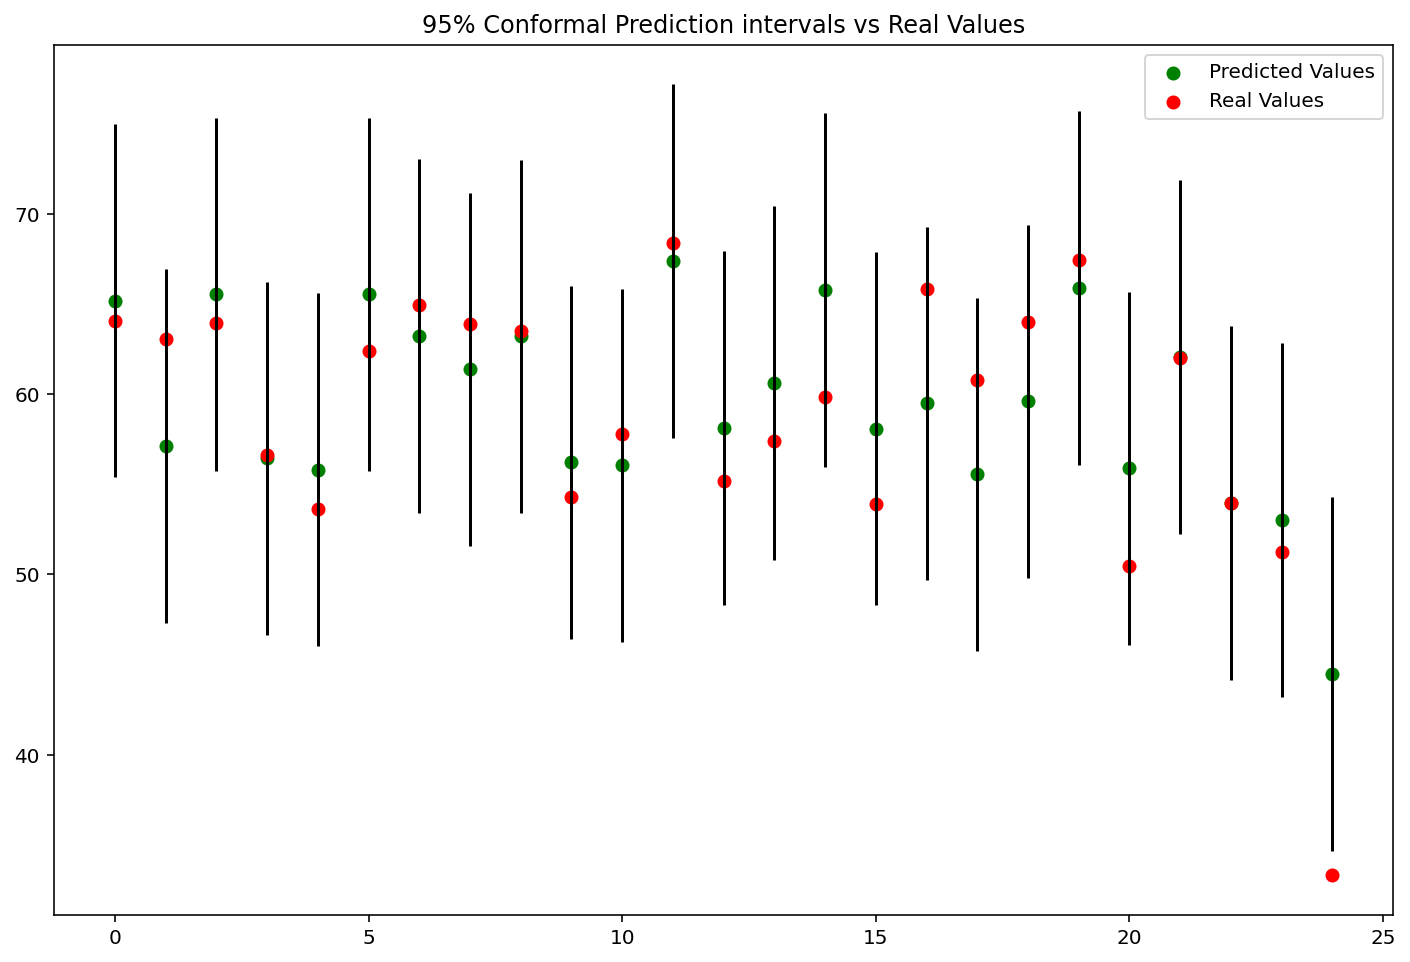

In [79]:
import matplotlib.pyplot as plt 

plt.rcParams["figure.figsize"] = (12,8)

y = punctual
x = np.arange(0,len(y))
yerr = [punctual-preds[:,0], preds[:,1] - punctual]

plt.errorbar(x=x,y=y,yerr= yerr, fmt='none', c= 'k')
plt.scatter(x,punctual, c = 'g', label = 'Predicted Values')
plt.scatter(x,y_test.iloc[test], c = 'r', label = 'Real Values')
plt.title('95% Conformal Prediction intervals vs Real Values');
plt.legend()

plt.savefig('Conformal')

In [7]:
from interpret.perf import RegressionPerf
from interpret import show


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = seed)
ebm = ExplainableBoostingRegressor(random_state=seed, n_jobs=-1, interactions = 6)
ebm.fit(X_train, y_train)


ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/1636105065952/ -->

<!-- http://127.0.0.1:7001/1636073903776/ -->